In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from Bio import SeqIO
import sys
sys.path.insert(0, '../models/')
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=""

from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger
from tensorflow.keras.regularizers import L2
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
#from tensorflow_addons.layers import GroupNormalization

import numpy as np
import h5py
import scipy.io
np.random.seed(1337) # for reproducibility

from tensorflow.keras.layers import Input, Conv1D, Dense, LSTM, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation, AveragePooling1D
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

from random import shuffle
#from pyfasta import Fasta
import gzip
import numpy as np
import re
import random


2025-04-01 14:53:40.750094: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 14:53:40.780053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-01 14:53:40.826016: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-01 14:53:40.837610: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 14:53:40.867918: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import tensorflow as tf
print("Num of GPUs available: ", len(tf.test.gpu_device_name()))

Num GPUs Available:  0
Num of GPUs available:  0


2025-04-01 14:53:44.382991: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-04-01 14:53:44.383106: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: ece-ashrafa-6s.eng.umanitoba.ca
2025-04-01 14:53:44.383118: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: ece-ashrafa-6s.eng.umanitoba.ca
2025-04-01 14:53:44.383343: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 530.30.2
2025-04-01 14:53:44.383401: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 530.30.2
2025-04-01 14:53:44.383410: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 530.30.2


In [3]:
from Bio import SeqIO

pos_seq = []
for seq_record in SeqIO.parse('../Dataset/S1-pos.txt', "fasta"):
    pos_seq.append(str(seq_record.seq.upper()))

# Calculate the maximum sequence length
max_length = max(len(seq) for seq in pos_seq)

# Pad all sequences to the maximum length
padded_pos_seq = [seq.ljust(max_length, 'N') for seq in pos_seq]

# Example: Print the first padded sequence and its length
print(f"Padded first sequence: {padded_pos_seq[0]}")
print(f"Length of padded first sequence: {len(padded_pos_seq[0])}")

# You can also print the max length for confirmation
print(f"Maximum sequence length: {max_length}")


Padded first sequence: CTTCGCCAGCCACTCTTAGTCCGCCAGCGCGTGCGGCGGAGGCCGAGCGTCTCTATGATCCTGGCTTCTGGCAACGTCATCGTCACGCGCCGGATCCAACCCCCAACCACTTTAGCCAGCTCTAGAGGCGCGCGTGGCCGGGACGGAAGTGCGCGCGGGTGTCGCCGGGAGTGCGCGCTCCTCTGGCTGACGGGCGGGCCGGGCATGCGCCGCGGGCGTTTTGGCGGGAAGCGCGGGGCGGGCCGGACAATGAGAGTGTCCGCCTCCNNNNNNNN
Length of padded first sequence: 275
Maximum sequence length: 275


In [4]:
from Bio import SeqIO

neg_seq = []
for seq_record in SeqIO.parse('../Dataset/S1-neg.txt', "fasta"):
    neg_seq.append(str(seq_record.seq.upper()))

# Calculate the maximum sequence length
max_length = max(len(seq) for seq in neg_seq)

# Pad all sequences to the maximum length
padded_neg_seq = [seq.ljust(max_length, 'N') for seq in neg_seq]

# Example: Print the first padded sequence and its length
print(f"Padded first sequence: {padded_neg_seq[0]}")
print(f"Length of padded first sequence: {len(padded_neg_seq[0])}")

# You can also print the max length for confirmation
print(f"Maximum sequence length: {max_length}")


Padded first sequence: GGCTCAGCACACACTTCACTGCTGCCGTCCCACACAGGAGCTCCAGGCTCGGATCAACCCAGCAGCAGGAAAGTCTTCTTCAACAGGGGCCAAGGCAGGATCCCCAAGGAGGCCACCTTCCAGAAACTGCTAAGGAACGAGGTCCGGGGGCCCCAAGCCCTGACTGGCACAGTCAGAGGAAAGTCAGGGCGGAGCTCAGCCCCCGTCCCCTCCCCTCGAGAGCGGGCCTGAGCCCCTGTCTCTCCATNNNNNNNNNNNNNNNNNNNNNNNNNNNN
Length of padded first sequence: 275
Maximum sequence length: 275


In [5]:
combine_seqs = padded_pos_seq + padded_neg_seq

In [6]:
bases = ['A','C','G','T']
def onehot(seq):
    X = np.zeros((len(seq),len(seq[0]), len(bases)))
    print(len(seq),len(seq[0]), len(bases))
    for l,s in enumerate(seq):
        for i, char in enumerate(s):
            if char in bases:
                X[l,i, bases.index(char)] = 1
    return X
def shuffle_ab(a,b):
    s = np.arange(a.shape[0])
    shuffle(s)
    return a[s],b[s]


In [7]:
lbs = list(np.ones(len(padded_pos_seq))) + list(np.zeros(len(padded_neg_seq)))

In [8]:
from sklearn.utils import compute_class_weight
#lbs = list(np.ones(len(pos_seq))) + list(np.zeros(len(neg_seq)))
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(lbs),
                                        y = lbs                                                    
                                    )
class_weights = dict(zip(np.unique(lbs), class_weights))
class_weights


{0.0: 0.6904761904761905, 1.0: 1.8125}

In [10]:
Inputs_features = onehot(combine_seqs)
Inputs_features=np.asarray(Inputs_features,dtype=np.float32)
Inputs_features.shape

1015 275 4


(1015, 275, 4)

In [11]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
one_hot_encoder = OneHotEncoder() 
lbs = np.array(lbs).reshape(-1, 1)
Input_labels = one_hot_encoder.fit_transform(lbs).toarray()
Input_labels = np.array(lbs)
Input_labels.shape

(1015, 1)

In [12]:
Input_labels = np.array(lbs)
Input_labels.shape

(1015, 1)

In [13]:
alld=[]
for i in range(len(Inputs_features)):
    alld.append([Inputs_features[i], Input_labels[i]])
np.random.shuffle(alld)   

In [14]:
x_train=[]
train_label=[]
for i in range(len(alld)):
    x_train+=[alld[i][0]]
    train_label+=[int(alld[i][1])]
print(np.shape(x_train),np.shape(train_label))

(1015, 275, 4) (1015,)


/tmp/ipykernel_1809596/2324041419.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_label+=[int(alld[i][1])]


In [15]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
one_hot_encoder = OneHotEncoder() 
train_label = np.array(train_label).reshape(-1, 1)
Input_labels = one_hot_encoder.fit_transform(train_label).toarray()
Input_labels = np.array(train_label)
Input_labels.shape

(1015, 1)

In [16]:
x_train=np.asarray(x_train)
y_train=np.asarray(train_label)

In [17]:
print(x_train.shape,Input_labels.shape)

(1015, 275, 4) (1015, 1)


In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
ix = 0
for train_index, test_index in kf.split(x_train):
    #print ("TRAIN:", len(train_index), "TEST:", len(test_index))
    #print train_index, test_index
    X_train,X_test=x_train[train_index], x_train[test_index]
    print (X_train.shape,X_test.shape)
    y_train,y_test=Input_labels[train_index], Input_labels[test_index]
    #print y_train,y_test
    np.save(f'sec_folds/fold_'+str(ix)+'_'+'x_train',X_train)
    np.save(f'sec_folds/fold_'+str(ix)+'_'+'x_test',X_test)
    np.save(f'sec_folds/fold_'+str(ix)+'_'+'y_train',y_train)
    np.save(f'sec_folds/fold_'+str(ix)+'_'+'y_test',y_test)
    ix+=1

(812, 275, 4) (203, 275, 4)
(812, 275, 4) (203, 275, 4)
(812, 275, 4) (203, 275, 4)
(812, 275, 4) (203, 275, 4)
(812, 275, 4) (203, 275, 4)


In [19]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

class CustomModelCheckpoint(Callback):
    def __init__(self, model, path):
        self.path = path
        self.model_for_saving = model

    def on_epoch_end(self, epoch, logs=None):
        loss = logs['val_loss']
        print("\nSaving model to : {}".format(self.path.format(epoch=epoch, val_loss=loss)))
        self.model_for_saving.save_weights(self.path.format(epoch=epoch, val_loss=loss), overwrite=True)

def step_decay(epoch):
    lrate = [0.001] * 30 + [0.0001] * 170  # List of learning rates for different epochs
    print(lrate[epoch])
    return lrate[epoch]

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) - tf.reduce_mean(
            (1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))

    return focal_loss_fixed


In [20]:
def build_model():
    inp1 = Input((275, 4))

    x1 = Conv1D(64, 7, strides=1, padding='same', activation='relu',
                kernel_regularizer=regularizers.l2(1e-5), bias_regularizer=regularizers.l2(1e-5),
                kernel_initializer='random_normal')(inp1)
    x1 = LayerNormalization()(x1)
    x1 = MaxPooling1D(pool_size=5)(x1)
    x1 = Dropout(0.5)(x1)
    x1 = Conv1D(128, 7, strides=1, padding='same', activation='relu',
                kernel_regularizer=regularizers.l2(1e-5), bias_regularizer=regularizers.l2(1e-5),
                kernel_initializer='random_normal')(x1)
    x1 = LayerNormalization()(x1)
    x1 = MaxPooling1D(pool_size=5)(x1)
    x1 = Dropout(0.5)(x1)
    x1 = Flatten()(x1)
    # **biGRU Branch for inp1**
#    x2 = GRU(64, return_sequences=False, dropout=0.15, recurrent_dropout=0.1)(inp1) #### best result on dropout=0.15

    
    # **Concatenation of CNN, biGRU, features**
#    x = concatenate([x1, x2], axis=1)
    x = Dropout(0.5)(x1)

    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inp1, outputs=x)
    return model

In [21]:
#set early stopping criteria
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

pat = 10 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define a function to fit the model
def fit_and_evaluate(train_features,train_labels,x_val_data,y_val, EPOCHS, BATCH_SIZE,fold):
    model = build_model()
    model.summary()
    opt = Adam(learning_rate=0.0001,amsgrad = False)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model_checkpoint = ModelCheckpoint(f'sec_folds/best_'+str(fold)+'_.keras',mode='min', monitor='val_loss', save_best_only=True,verbose=1)
    lrate = LearningRateScheduler(step_decay)
    reduct_L_rate = ReduceLROnPlateau(monitor='val_loss',factor=0.01, patience=20)
    callbacks = [lrate,model_checkpoint]
    results = model.fit(train_features, train_labels,batch_size=BATCH_SIZE,epochs=EPOCHS,shuffle=True,class_weight=class_weights, validation_data= (x_val_data, y_val),callbacks=callbacks)
    print("Val Score: ", model.evaluate(x_val_data, y_val))
    return results 


In [22]:
from sklearn.model_selection import train_test_split
epochs=70
batch_size=64

#save the model history in a list after fitting so that we can plot later
model_history = [] 

#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
i = 1
for i in range(5):
    x=str(i)
    print("Training on Fold: ",i+1)
    train_features,train_labels=np.load(f'sec_folds/fold_'+x+'_x_train.npy'), np.load(f'sec_folds/fold_'+x+'_y_train.npy')
    x_val_data,y_val=np.load(f'sec_folds/fold_'+x+'_x_test.npy'), np.load(f'sec_folds/fold_'+x+'_y_test.npy')

    model_history.append(fit_and_evaluate(train_features,train_labels,x_val_data,y_val,epochs, batch_size,i))
    print("======="*12, end="\n\n\n")

Training on Fold:  1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 275, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 275, 64)        │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 275, 64)        │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 55, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 55, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 55, 128)        │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 55, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,409 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,121 (238.75 KB)

 Trainable params: 61,121 (238.75 KB)

 Non-trainable params: 0 (0.00 B)

0.001
Epoch 1/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5032 - loss: 1.7149
Epoch 1: val_loss improved from inf to 0.87172, saving model to sec_folds/best_0_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.5055 - loss: 1.7077 - val_accuracy: 0.4532 - val_loss: 0.8717 - learning_rate: 0.0010
0.001
Epoch 2/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4958 - loss: 1.5453
Epoch 2: val_loss improved from 0.87172 to 0.57964, saving model to sec_folds/best_0_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4994 - loss: 1.5355 - val_accuracy: 0.7340 - val_loss: 0.5796 - learning_rate: 0.0010
0.001
Epoch 3/70
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5491 - loss: 1.2550
Epoch 3: val_loss did not improve from 0.57964
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5514 - loss: 1.2529 - val_accuracy: 0.6946 - val_loss: 0.6064 - learning_rate: 0.0010
0.001
Epoch 4/70
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6213 - l

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 275, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 275, 64)        │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 275, 64)        │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 55, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 55, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 55, 128)        │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 55, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,409 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,121 (238.75 KB)

 Trainable params: 61,121 (238.75 KB)

 Non-trainable params: 0 (0.00 B)

0.001
Epoch 1/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5008 - loss: 1.6254
Epoch 1: val_loss improved from inf to 0.57703, saving model to sec_folds/best_1_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.5024 - loss: 1.6240 - val_accuracy: 0.6946 - val_loss: 0.5770 - learning_rate: 0.0010
0.001
Epoch 2/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5470 - loss: 1.4248
Epoch 2: val_loss improved from 0.57703 to 0.52669, saving model to sec_folds/best_1_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5473 - loss: 1.4223 - val_accuracy: 0.7537 - val_loss: 0.5267 - learning_rate: 0.0010
0.001
Epoch 3/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5757 - loss: 1.2607
Epoch 3: val_loss did not improve from 0.52669
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5769 - loss: 1.2587 - val_accuracy: 0.7044 - val_loss: 0.5919 - learning_rate: 0.0010
0.001
Epoch 4/70
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4933 - lo

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 275, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 275, 64)        │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 275, 64)        │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 55, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 55, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 55, 128)        │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 55, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,409 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,121 (238.75 KB)

 Trainable params: 61,121 (238.75 KB)

 Non-trainable params: 0 (0.00 B)

0.001
Epoch 1/70
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5459 - loss: 1.4851
Epoch 1: val_loss improved from inf to 0.50156, saving model to sec_folds/best_2_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.5458 - loss: 1.4845 - val_accuracy: 0.7537 - val_loss: 0.5016 - learning_rate: 0.0010
0.001
Epoch 2/70
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5679 - loss: 1.4181
Epoch 2: val_loss did not improve from 0.50156
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5642 - loss: 1.4174 - val_accuracy: 0.7882 - val_loss: 0.5138 - learning_rate: 0.0010
0.001
Epoch 3/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5169 - loss: 1.5498
Epoch 3: val_loss improved from 0.50156 to 0.47200, saving model to sec_folds/best_2_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5191 - loss: 1.5333 - val_accuracy: 0.7685 - val_loss: 0.4720 - learning_rate: 0.0010
0.001
Epoch 4/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5610 - lo

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 275, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 275, 64)        │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_6           │ (None, 275, 64)        │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 55, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 55, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 55, 128)        │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_7           │ (None, 55, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,409 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,121 (238.75 KB)

 Trainable params: 61,121 (238.75 KB)

 Non-trainable params: 0 (0.00 B)

0.001
Epoch 1/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5022 - loss: 1.6899
Epoch 1: val_loss improved from inf to 0.59395, saving model to sec_folds/best_3_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.5036 - loss: 1.6910 - val_accuracy: 0.6946 - val_loss: 0.5939 - learning_rate: 0.0010
0.001
Epoch 2/70
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5496 - loss: 1.4862
Epoch 2: val_loss did not improve from 0.59395
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5484 - loss: 1.4667 - val_accuracy: 0.6502 - val_loss: 0.6038 - learning_rate: 0.0010
0.001
Epoch 3/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5626 - loss: 1.3761
Epoch 3: val_loss improved from 0.59395 to 0.57538, saving model to sec_folds/best_3_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5626 - loss: 1.3652 - val_accuracy: 0.6946 - val_loss: 0.5754 - learning_rate: 0.0010
0.001
Epoch 4/70
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6075 - lo

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 275, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 275, 64)        │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_8           │ (None, 275, 64)        │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 55, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 55, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 55, 128)        │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_9           │ (None, 55, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,409 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,121 (238.75 KB)

 Trainable params: 61,121 (238.75 KB)

 Non-trainable params: 0 (0.00 B)

0.001
Epoch 1/70
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4912 - loss: 1.7848
Epoch 1: val_loss improved from inf to 0.54449, saving model to sec_folds/best_4_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.4946 - loss: 1.7724 - val_accuracy: 0.7537 - val_loss: 0.5445 - learning_rate: 0.0010
0.001
Epoch 2/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5362 - loss: 1.5942
Epoch 2: val_loss did not improve from 0.54449
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5363 - loss: 1.5878 - val_accuracy: 0.7044 - val_loss: 0.5709 - learning_rate: 0.0010
0.001
Epoch 3/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5349 - loss: 1.3834
Epoch 3: val_loss did not improve from 0.54449
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5342 - loss: 1.3795 - val_accuracy: 0.5468 - val_loss: 0.7590 - learning_rate: 0.0010
0.001
Epoch 4/70
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5195 - loss: 1.3070
Epoch 4: val_loss improved from 0.

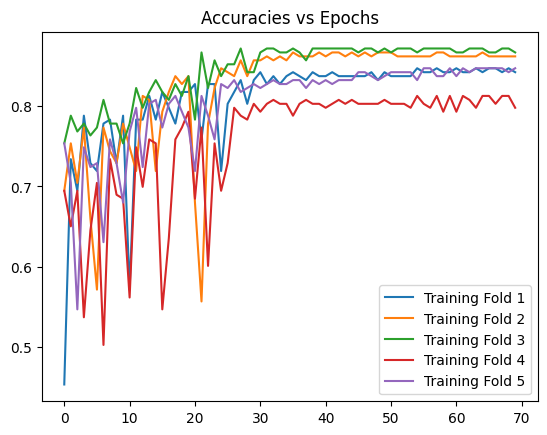

In [23]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['val_accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['val_accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['val_accuracy'], label='Training Fold 3')
plt.plot(model_history[3].history['val_accuracy'], label='Training Fold 4')
plt.plot(model_history[4].history['val_accuracy'], label='Training Fold 5')
plt.legend()
plt.show()

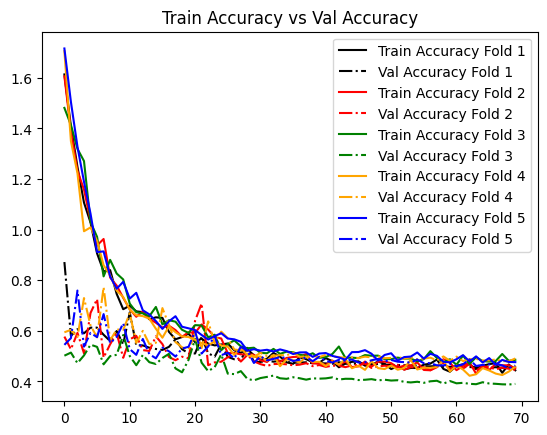

In [24]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['loss'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_loss'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['loss'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_loss'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['loss'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_loss'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['loss'], label='Train Accuracy Fold 4', color='orange', )
plt.plot(model_history[3].history['val_loss'], label='Val Accuracy Fold 4', color='orange', linestyle = "dashdot")
plt.plot(model_history[4].history['loss'], label='Train Accuracy Fold 5', color='blue', )
plt.plot(model_history[4].history['val_loss'], label='Val Accuracy Fold 5', color='blue', linestyle = "dashdot")
plt.legend()
plt.show()

Result on val_Fold:  1
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8448 - loss: 0.4698  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
Result on val_Fold:  2
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8578 - loss: 0.4404  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
Result on val_Fold:  3
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8658 - loss: 0.3840  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 
Result on val_Fold:  4
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8481 - loss: 0.4110 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step 
Result on val_Fold:  5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8709 - loss: 0.4247
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step 
###################### Training Performance ####################
Average Accuracy: 0.8463 ± 0.0252
Average Sensitivity: 0.6316 ± 0.0434
Average Specificity: 0.9297 ± 0.0269
Average MCC: 0.5993 ± 0.0516
Average ROC AUC: 0.8171 ± 0.0496
Average PR AUC: 0.7019 ± 0.0311
############################################################

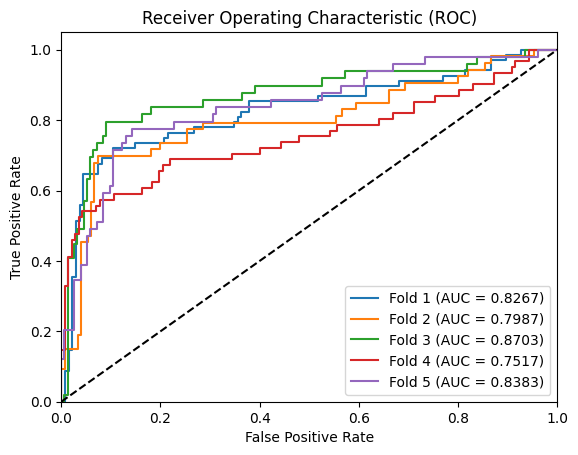

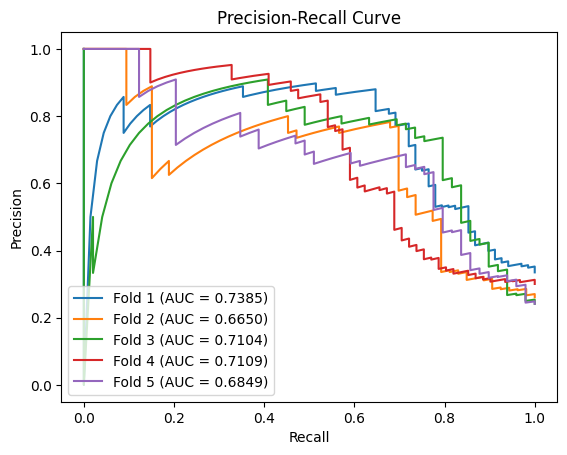

In [26]:
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt
from scipy import stats

# Define specificity function
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Initialize lists to store metrics for each fold
mcc_list = []
spe_list = []
sen_list = []
acc_list = []
roc_auc_list = []
pr_auc_list = []

# Initialize lists for plotting
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []

for i in range(5):
    x = str(i)
    print("Result on val_Fold: ", i + 1)
    
    # Load the model and data
    model = load_model(f'sec_folds/best_' + str(i) + '_.keras')
    x_val_data1 = np.load(f'sec_folds/fold_' + x + '_x_test.npy')
    test_labels = np.load(f'sec_folds/fold_' + x + '_y_test.npy')

    
    # Evaluate the model
    model.evaluate(x_val_data1, test_labels)
    
    # Get predictions
    y_scores = model.predict(x_val_data1)
    
    # Check the shape of y_scores and adjust if necessary
    if y_scores.shape[1] == 1:
        y_scores = np.hstack([1 - y_scores, y_scores])
    
    y_pred = np.argmax(y_scores, axis=1)
    
    # Calculate performance metrics
    acc = accuracy_score(test_labels, y_pred)
    sen = recall_score(test_labels, y_pred)
    spe = specificity(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred, zero_division=1)
    f1 = f1_score(test_labels, y_pred, zero_division=1)
    mcc = matthews_corrcoef(test_labels, y_pred)
    
    # Compute AUC for ROC and PR
    y_scores_pos = y_scores[:, 1]  # Probabilities for the positive class
    fpr, tpr, _ = roc_curve(test_labels, y_scores_pos)
    auc_roc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(test_labels, y_scores_pos)
    auc_pr = average_precision_score(test_labels, y_scores_pos)
    
    # Append metrics to lists
    acc_list.append(acc)
    sen_list.append(sen)
    spe_list.append(spe)
    mcc_list.append(mcc)
    roc_auc_list.append(auc_roc)
    pr_auc_list.append(auc_pr)
    
    # Store values for plotting
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    precision_list.append(precision)
    recall_list.append(recall)

# Calculate average metrics
avg_acc = np.mean(acc_list)
avg_sen = np.mean(sen_list)
avg_spe = np.mean(spe_list)
avg_mcc = np.mean(mcc_list)
avg_roc_auc = np.mean(roc_auc_list)
avg_pr_auc = np.mean(pr_auc_list)

# Calculate standard deviations for each metric
std_acc = np.std(acc_list)
std_sen = np.std(sen_list)
std_spe = np.std(spe_list)
std_mcc = np.std(mcc_list)
std_roc_auc = np.std(roc_auc_list)
std_pr_auc = np.std(pr_auc_list)

# Number of folds
n = len(acc_list)

# Calculate 95% confidence intervals for each metric
ci_acc = stats.t.interval(0.95, n-1, loc=avg_acc, scale=std_acc/np.sqrt(n))
ci_sen = stats.t.interval(0.95, n-1, loc=avg_sen, scale=std_sen/np.sqrt(n))
ci_spe = stats.t.interval(0.95, n-1, loc=avg_spe, scale=std_spe/np.sqrt(n))
ci_mcc = stats.t.interval(0.95, n-1, loc=avg_mcc, scale=std_mcc/np.sqrt(n))
ci_roc_auc = stats.t.interval(0.95, n-1, loc=avg_roc_auc, scale=std_roc_auc/np.sqrt(n))
ci_pr_auc = stats.t.interval(0.95, n-1, loc=avg_pr_auc, scale=std_pr_auc/np.sqrt(n))

print("###################### Training Performance ####################")

# Print the average metrics with confidence intervals
print(f'Average Accuracy: {avg_acc:.4f} ± {ci_acc[1] - avg_acc:.4f}')
print(f'Average Sensitivity: {avg_sen:.4f} ± {ci_sen[1] - avg_sen:.4f}')
print(f'Average Specificity: {avg_spe:.4f} ± {ci_spe[1] - avg_spe:.4f}')
print(f'Average MCC: {avg_mcc:.4f} ± {ci_mcc[1] - avg_mcc:.4f}')
print(f'Average ROC AUC: {avg_roc_auc:.4f} ± {ci_roc_auc[1] - avg_roc_auc:.4f}')
print(f'Average PR AUC: {avg_pr_auc:.4f} ± {ci_pr_auc[1] - avg_pr_auc:.4f}')
print("###############################################################")

# Plot ROC Curve
plt.figure()
for i in range(5):
    plt.plot(fpr_list[i], tpr_list[i], label=f'Fold {i+1} (AUC = {roc_auc_list[i]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.savefig('average_roc_curve.png')
plt.show()

# Plot PR Curve
plt.figure()
for i in range(5):
    plt.plot(recall_list[i], precision_list[i], label=f'Fold {i+1} (AUC = {pr_auc_list[i]:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig('average_pr_curve.png')
plt.show()
